## Analysis of CW H841 variants
- Use data after Dropkick processing and MT and RP gene filtering


In [1]:
import os
import sys
import scvelo as scv
import scanpy as sc
import os.path as op
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import dropkick as dk
import cellrank as cr
import scanorama
from mazebox_filter import dropkick_filter, dropkick_recipe, doublet_detections
from pathlib import Path

## Define write file locations
Should still work the same for any Tempo user without creating new directories for Monica and allowing speedup by allowing prevention of overwriting files if they already exist.  

In [2]:
SAVEDATA = True
OVERWRITE = False
SAVEDIR = op.expanduser("~/rna_seq")
if not op.exists(SAVEDIR):
    os.mkdir(SAVEDIR)
          
%matplotlib inline

### Read Data

In [3]:
# save as h5ad
h841_mt_rp_filtered_fn = 'adata_H841_mt_rp_filter.h5ad'

if (not op.exists(Path(SAVEDIR,h841_mt_rp_filtered_fn))):
    print(f'Cannot find data file: {Path(SAVEDIR,h841_mt_rp_filtered_fn)}')
else:
    print(f'Loading data in {Path(SAVEDIR,h841_mt_rp_filtered_fn)}')
print()


Cannot find data file: /Users/darren/rna_seq/adata_H841_mt_rp_filter.h5ad



In [26]:
# load adata (before pca)
adata2 = sc.read_h5ad(Path(SAVEDIR,h841_mt_rp_filtered_fn))
adata2

AnnData object with n_obs × n_vars = 7267 × 18030
    obs: 'dropkick_score', 'dropkick_label', 'arcsinh_n_genes_by_counts', 'AW_H841_sample', 'initial_size', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ambient', 'log1p_total_counts_ambient', 'pct_counts_ambient', 'arcsinh_total_counts', 'S_score', 'G2M_score', 'phase'
    var: 'dropkick_coef-S1 H841_KOR', 'dropkick_coef-S2 H841_RESTko', 'dropkick_coef-S3 H841_Hes1ko', 'dropkick_coef-S4 H841_NR0B1ko', 'dropkick_coef-S5 H841_ELF3ko', 'mito', 'pct_dropout_by_counts', 'ambient', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'total_counts', 'log1p_total_counts', 'mean', 'std', 'ribo'
    uns: 'AW_H841_sample_colors', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'arcsinh_norm', 'log1p_norm', 'raw_counts'

In [27]:
adata2.obs_names

Index(['TGATTTACCCTCAACGTGG-S1 H841_KOR', 'GACGAATAATCTTGGTGT-S1 H841_KOR',
       'TTGCATATGGTTTCTC-S1 H841_KOR', 'TGACGGGTAGTGACAGATA-S1 H841_KOR',
       'TTGCATATCCACATTA-S1 H841_KOR', 'GTTACGATTGAGGTCT-S1 H841_KOR',
       'AAAACCTCCAGTGATGC-S1 H841_KOR', 'TCATCCTTACGCCATT-S1 H841_KOR',
       'AGAGACTATCTCAACC-S1 H841_KOR', 'TGATGTGGCTAACACTAAG-S1 H841_KOR',
       ...
       'TGAGAAGCACTTAGTCGCA-S5 H841_ELF3ko',
       'AGTATGAGTCTTCTTCG-S5 H841_ELF3ko', 'ACGGAATTTATTCCTTG-S5 H841_ELF3ko',
       'ACTACTTGTTTGAGGGT-S5 H841_ELF3ko', 'GACACGGACTACGGTAGC-S5 H841_ELF3ko',
       'AATGCGGATACTAGGAT-S5 H841_ELF3ko', 'TTCGGCCTAAACTGGT-S5 H841_ELF3ko',
       'ATTTGGGAGCGTCAGCA-S5 H841_ELF3ko', 'AGGCAACGTACAAACT-S5 H841_ELF3ko',
       'GAACTAGGATCGTCAGCA-S5 H841_ELF3ko'],
      dtype='object', length=7267)

In [28]:
# get list of obs_names
x = adata2.obs_names.tolist()
len(x)

7267

In [29]:
# remove outlier from list
x.remove('TGCGACAGATACTCTT-S1 H841_KOR')
len(x)

7266

In [30]:
# get view (anndata subset) with new list
filtered = adata2[x].copy()
filtered

AnnData object with n_obs × n_vars = 7266 × 18030
    obs: 'dropkick_score', 'dropkick_label', 'arcsinh_n_genes_by_counts', 'AW_H841_sample', 'initial_size', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ambient', 'log1p_total_counts_ambient', 'pct_counts_ambient', 'arcsinh_total_counts', 'S_score', 'G2M_score', 'phase'
    var: 'dropkick_coef-S1 H841_KOR', 'dropkick_coef-S2 H841_RESTko', 'dropkick_coef-S3 H841_Hes1ko', 'dropkick_coef-S4 H841_NR0B1ko', 'dropkick_coef-S5 H841_ELF3ko', 'mito', 'pct_dropout_by_counts', 'ambient', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'total_counts', 'log1p_total_counts', 'mean', 'std', 'ribo'
    uns: 'AW_H841_sample_colors', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'arcsinh_norm', 'log1p_norm', 'raw_counts'

In [31]:
# run pca again
sc.tl.pca(filtered, use_highly_variable=False)
filtered

AnnData object with n_obs × n_vars = 7266 × 18030
    obs: 'dropkick_score', 'dropkick_label', 'arcsinh_n_genes_by_counts', 'AW_H841_sample', 'initial_size', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ambient', 'log1p_total_counts_ambient', 'pct_counts_ambient', 'arcsinh_total_counts', 'S_score', 'G2M_score', 'phase'
    var: 'dropkick_coef-S1 H841_KOR', 'dropkick_coef-S2 H841_RESTko', 'dropkick_coef-S3 H841_Hes1ko', 'dropkick_coef-S4 H841_NR0B1ko', 'dropkick_coef-S5 H841_ELF3ko', 'mito', 'pct_dropout_by_counts', 'ambient', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'total_counts', 'log1p_total_counts', 'mean', 'std', 'ribo'
    uns: 'AW_H841_sample_colors', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'arcsinh_norm', 'log1p_norm', 'raw_counts'

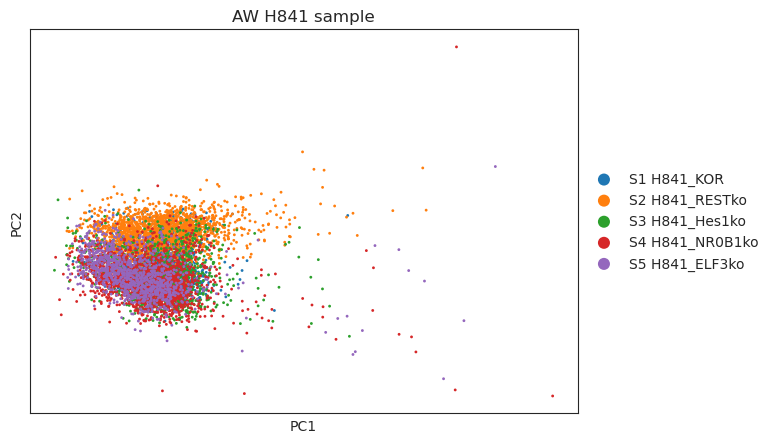

In [32]:
sc.pl.scatter(filtered, basis='pca',color='AW_H841_sample')

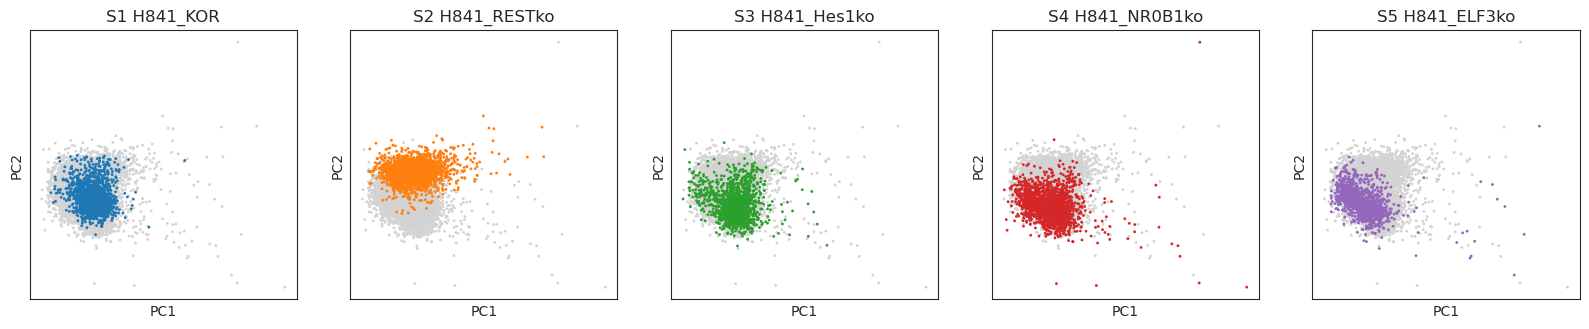

In [33]:
fig4, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20,3.5))
ax1_dict = sc.pl.scatter(filtered, basis='pca',color=['AW_H841_sample'], groups='S1 H841_KOR', ax=ax1, show=False, title=['S1 H841_KOR'], legend_loc='none')
ax2_dict = sc.pl.scatter(filtered, basis='pca',color=['AW_H841_sample'], groups='S2 H841_RESTko', ax=ax2, show=False, title=['S2 H841_RESTko'], legend_loc='none')
ax3_dict = sc.pl.scatter(filtered, basis='pca',color=['AW_H841_sample'], groups='S3 H841_Hes1ko', ax=ax3, show=False, title=['S3 H841_Hes1ko'], legend_loc='none')
ax4_dict = sc.pl.scatter(filtered, basis='pca',color=['AW_H841_sample'], groups='S4 H841_NR0B1ko', ax=ax4, show=False, title=['S4 H841_NR0B1ko'], legend_loc='none')
ax5_dict = sc.pl.scatter(filtered, basis='pca',color=['AW_H841_sample'], groups='S5 H841_ELF3ko', ax=ax5, show=False, title=['S5 H841_ELF3ko'], legend_loc='none')

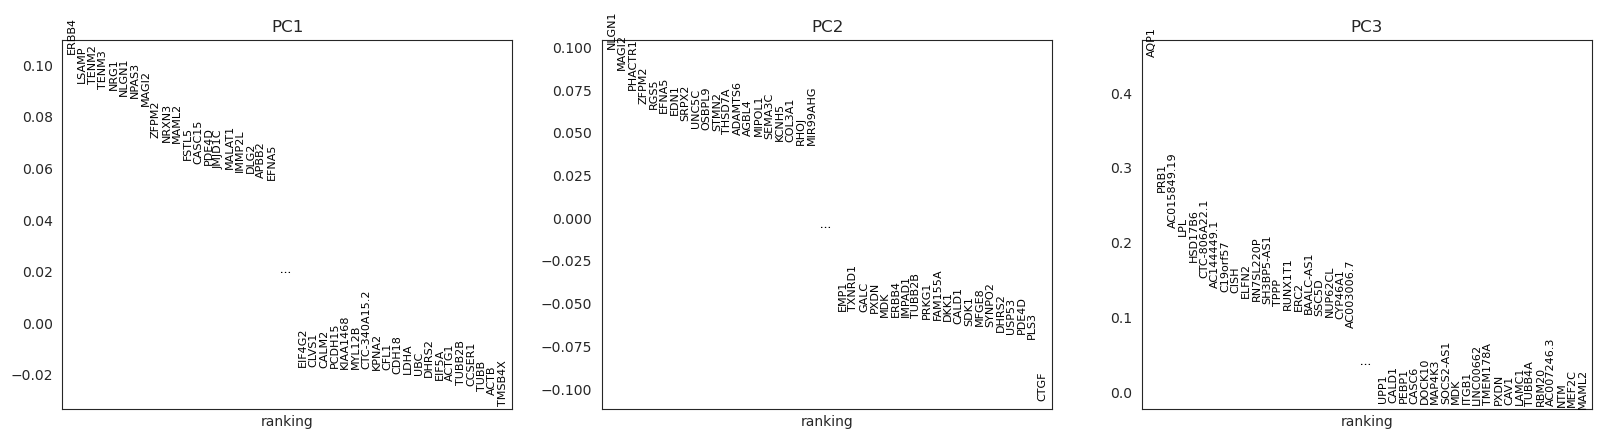

In [34]:
sc.pl.pca_loadings(filtered, n_points=40)

**KDE plots**

In [35]:
subset_df = sc.get.obs_df(
        filtered,
        keys=['AW_H841_sample'],
        obsm_keys=[("X_pca", 0), ("X_pca", 1)])
subset_df

,AW_H841_sample,X_pca-0,X_pca-1
TGATTTACCCTCAACGTGG-S1 H841_KOR,S1 H841_KOR,-1.217247,0.382459
GACGAATAATCTTGGTGT-S1 H841_KOR,S1 H841_KOR,-3.247614,3.518538
TTGCATATGGTTTCTC-S1 H841_KOR,S1 H841_KOR,-4.500349,0.451559
TGACGGGTAGTGACAGATA-S1 H841_KOR,S1 H841_KOR,-1.469441,3.194627
TTGCATATCCACATTA-S1 H841_KOR,S1 H841_KOR,-3.044098,0.734575
...,...,...,...
AATGCGGATACTAGGAT-S5 H841_ELF3ko,S5 H841_ELF3ko,0.959362,-4.849828
TTCGGCCTAAACTGGT-S5 H841_ELF3ko,S5 H841_ELF3ko,3.733522,-4.702773
ATTTGGGAGCGTCAGCA-S5 H841_ELF3ko,S5 H841_ELF3ko,8.939729,-1.399803
AGGCAACGTACAAACT-S5 H841_ELF3ko,S5 H841_ELF3ko,-1.581424,0.645487


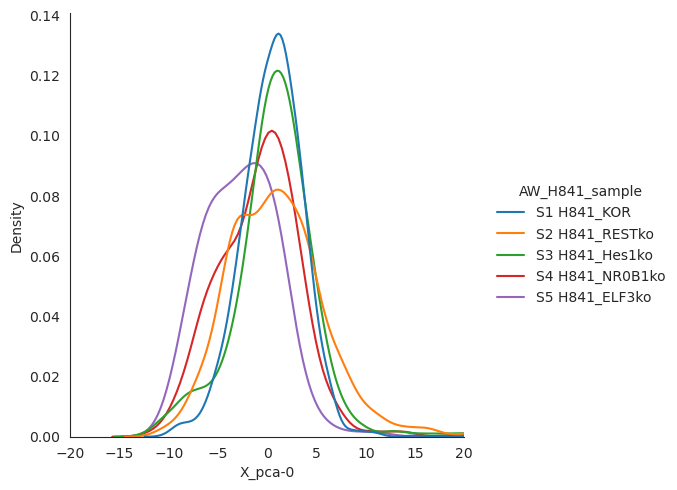

In [36]:
fig5 = sns.displot(subset_df, x='X_pca-0', hue='AW_H841_sample', kind="kde", common_norm=False, facet_kws=dict(sharex=True, xlim=(-20, 20)))

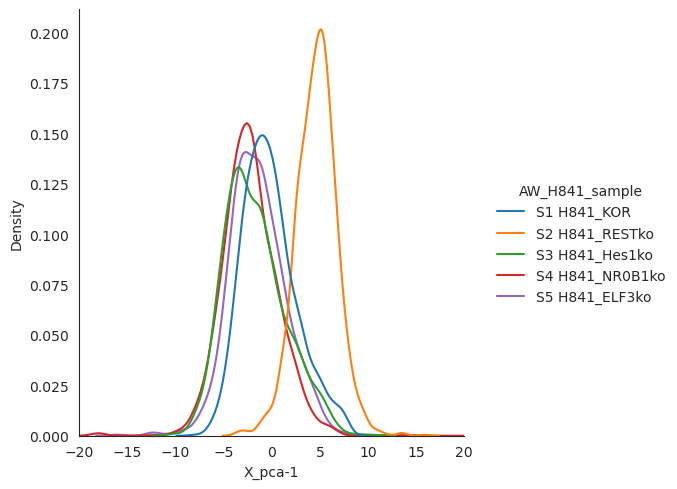

In [37]:
fig6 = sns.displot(subset_df, x='X_pca-1', hue='AW_H841_sample', kind="kde", common_norm=False, facet_kws=dict(sharex=True, xlim=(-20, 20)))

In [38]:
sc.pp.neighbors(filtered)
sc.tl.umap(filtered)

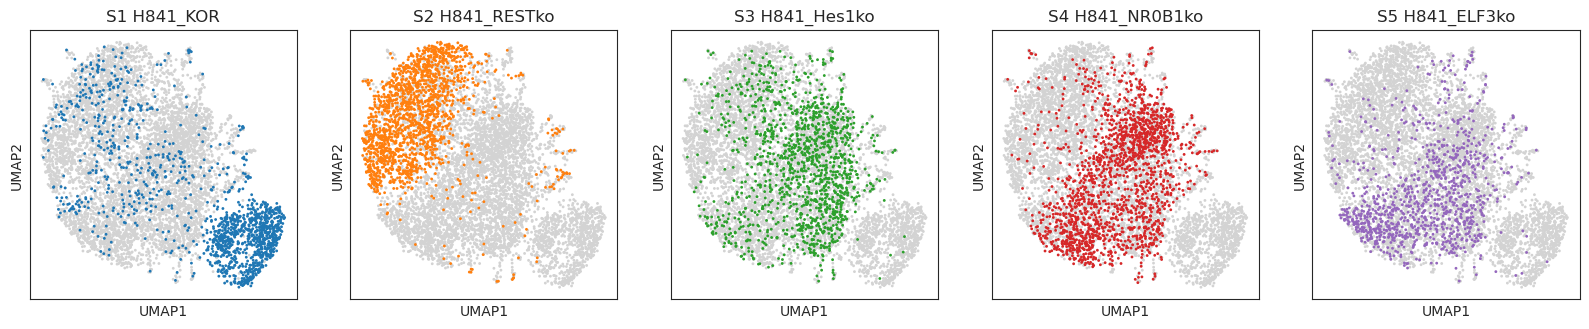

In [39]:
fig7, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20,3.5))
ax1_dict = sc.pl.umap(filtered, color=['AW_H841_sample'], groups='S1 H841_KOR', ax=ax1, show=False, title=['S1 H841_KOR'], legend_loc='none')
ax2_dict = sc.pl.umap(filtered, color=['AW_H841_sample'], groups='S2 H841_RESTko', ax=ax2, show=False, title=['S2 H841_RESTko'], legend_loc='none')
ax3_dict = sc.pl.umap(filtered, color=['AW_H841_sample'], groups='S3 H841_Hes1ko', ax=ax3, show=False, title=['S3 H841_Hes1ko'], legend_loc='none')
ax4_dict = sc.pl.umap(filtered, color=['AW_H841_sample'], groups='S4 H841_NR0B1ko', ax=ax4, show=False, title=['S4 H841_NR0B1ko'], legend_loc='none')
ax5_dict = sc.pl.umap(filtered, color=['AW_H841_sample'], groups='S5 H841_ELF3ko', ax=ax5, show=False, title=['S5 H841_ELF3ko'], legend_loc='none')

In [40]:
sc.tl.leiden(filtered, key_added='clusters', resolution=0.15)

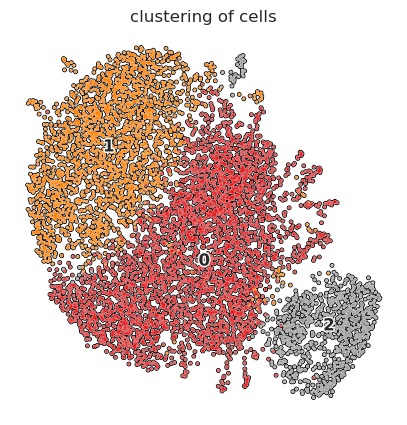

In [41]:
with plt.rc_context({'figure.figsize': (5, 5)}):
    sc.pl.umap(filtered, color='clusters', add_outline=True, legend_loc='on data',
               legend_fontsize=12, legend_fontoutline=2,frameon=False,
               title='clustering of cells', palette='Set1')

In [42]:
subtype_gene_list = pd.read_csv("Wooten SCLC TF network states gene list.csv")

In [43]:
# marker_genes_dict = {
#     'A': subtype_gene_list['Gene'][subtype_gene_list['A']==1.0],
#     'A2': subtype_gene_list['Gene'][subtype_gene_list['A2']==1.0],
#     'N': subtype_gene_list['Gene'][subtype_gene_list['N']==1.0],
#     'nonNE': subtype_gene_list['Gene'][subtype_gene_list['nonNE']==1.0],
# }

wooten_network_genes = {
    'SCLC': [x for x in subtype_gene_list['Gene'] if x in filtered.var_names]
}

In [44]:
wooten_network_genes

{'SCLC': ['FOXA1',
  'RBPJ',
  'FLI1',
  'SMAD4',
  'BCL3',
  'STAT6',
  'ISL1',
  'CEBPD',
  'EBF1',
  'TCF4',
  'RCOR2',
  'TCF3',
  'OLIG2',
  'MITF',
  'TEAD4',
  'ZNF217',
  'GATA4',
  'REST']}

### Remove gene names that are not in `filtered.var_names`

In [45]:
# marker_genes_dict = {
#     'A': [x for x in marker_genes_dict['A'] if x in filtered.var_names],
#     'A2': [x for x in marker_genes_dict['A2'] if x in filtered.var_names],
#     'N': [x for x in marker_genes_dict['N'] if x in filtered.var_names],
#     'nonNE': [x for x in marker_genes_dict['nonNE'] if x in filtered.var_names],
# }

# marker_genes_dict

categories: 0, 1, 2
var_group_labels: SCLC


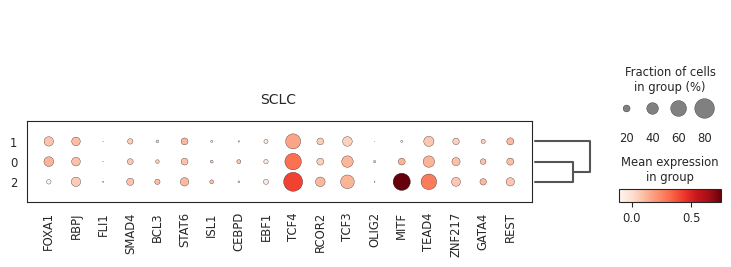

In [46]:
sc.pl.dotplot(filtered, wooten_network_genes, 'clusters', dendrogram=True)